In [361]:
from collections import Counter
import json
import requests, sys, os
import time
import xmltodict

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [389]:
df = pd.read_csv("results/cnv_phenotypes.csv")
df.dropna(subset=["Protein_coding_genes"], inplace=True)
df.reset_index(drop=True, inplace=True)
df["Start"] = df["Start"].astype(int)
df["End"] = df["End"].astype(int)
df["CNV_length"] = df["End"] - df["Start"]

converters = ["FEP", "Converter"]
non_converters = ["Non_converter"]

# Drop UHR and NUHR
df = df[df["Phenotype"].isin(converters + non_converters)]

print(f"""Number of converters: {len(df[df['Phenotype'].isin(converters)]['ID_WGS'].unique())}""")
print(f"""Number of non-converters: {len(df[df['Phenotype'].isin(non_converters)]['ID_WGS'].unique())}\n""")

Number of converters: 294
Number of non-converters: 63



## DEL vs DUP between FEP+CONV and NON_CONV

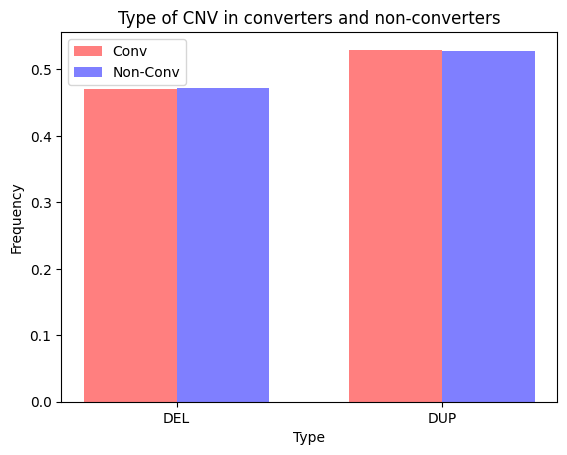

In [390]:
conv_del = sum((df["Type"] == "DEL") & df["Phenotype"].isin(converters)) / len(df[df["Phenotype"].isin(converters)])
conv_dup = sum((df["Type"] == "DUP") & (df["Phenotype"].isin(converters))) / len(df[df["Phenotype"].isin(converters)])
non_conv_del = sum((df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))) / len(df[df["Phenotype"].isin(non_converters)])
non_conv_dup = sum((df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))) / len(df[df["Phenotype"].isin(non_converters)])

conv_counts = [conv_del, conv_dup]
non_conv_counts = [non_conv_del, non_conv_dup]
categories = ["DEL", "DUP"]
width = 0.35  

fig, ax = plt.subplots()
conv_bars = ax.bar(np.arange(len(categories)) - width/2, conv_counts, width, label="Conv", color="red", alpha=0.5)
non_conv_bars = ax.bar(np.arange(len(categories)) + width/2, non_conv_counts, width, label="Non-Conv", color="blue", alpha=0.5)

ax.set_xlabel("Type")
ax.set_ylabel("Frequency")
ax.set_title("Type of CNV in converters and non-converters")
ax.set_xticks(np.arange(len(categories)))
ax.set_xticklabels(categories)
ax.legend()

plt.show()


In [337]:
print(f"""Number of DEL in converters: {sum((df["Type"] == "DEL") & (df["Phenotype"].isin(converters)))}""")
print(f"""Number of DUP in converters: {sum((df["Type"] == "DUP") & (df["Phenotype"].isin(converters)))}""")
print(f"""Number of DEL in non-converters: {sum((df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters)))}""")
print(f"""Number of DUP in non-converters: {sum((df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters)))}""")



Number of DEL in converters: 6552
Number of DUP in converters: 7381
Number of DEL in non-converters: 1444
Number of DUP in non-converters: 1611


In [338]:
print(f"""Average length of DEL in converters: {df[(df["Type"] == "DEL") & (df["Phenotype"].isin(converters))]["CNV_length"].mean()}""")
print(f"""Average length of DUP in converters: {df[(df["Type"] == "DUP") & (df["Phenotype"].isin(converters))]["CNV_length"].mean()}""")
print(f"""Average length of DEL in non-converters: {df[(df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))]["CNV_length"].mean()}""")
print(f"""Average length of DUP in non-converters: {df[(df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))]["CNV_length"].mean()}""")


Average length of DEL in converters: 34671.57264957265
Average length of DUP in converters: 60313.793794878744
Average length of DEL in non-converters: 35962.13365650969
Average length of DUP in non-converters: 145659.94351334576


In [339]:
print(f"""SD of DEL in converters: {df[(df["Type"] == "DEL") & (df["Phenotype"].isin(converters))]["CNV_length"].std()}""")
print(f"""SD of DUP in converters: {df[(df["Type"] == "DUP") & (df["Phenotype"].isin(converters))]["CNV_length"].std()}""")
print(f"""SD of DEL in non-converters: {df[(df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))]["CNV_length"].std()}""")
print(f"""SD of DUP in non-converters: {df[(df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))]["CNV_length"].std()}""")


SD of DEL in converters: 48687.960983026314
SD of DUP in converters: 88457.87264527484
SD of DEL in non-converters: 57826.74212312708
SD of DUP in non-converters: 617062.9825658727


In [340]:
print(f"""Min length of DEL in converters: {df[(df["Type"] == "DEL") & (df["Phenotype"].isin(converters))]["CNV_length"].min()}""")
print(f"""Min length of DUP in converters: {df[(df["Type"] == "DUP") & (df["Phenotype"].isin(converters))]["CNV_length"].min()}""")
print(f"""Min length of DEL in non-converters: {df[(df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))]["CNV_length"].min()}""")
print(f"""Min length of DUP in non-converters: {df[(df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))]["CNV_length"].min()}""")


Min length of DEL in converters: 9999
Min length of DUP in converters: 10007
Min length of DEL in non-converters: 10016
Min length of DUP in non-converters: 10091


In [341]:
print(f"""Max length of DEL in converters: {df[(df["Type"] == "DEL") & (df["Phenotype"].isin(converters))]["CNV_length"].max()}""")
print(f"""Max length of DUP in converters: {df[(df["Type"] == "DUP") & (df["Phenotype"].isin(converters))]["CNV_length"].max()}""")
print(f"""Max length of DEL in non-converters: {df[(df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))]["CNV_length"].max()}""")
print(f"""Max length of DUP in non-converters: {df[(df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))]["CNV_length"].max()}""")

Max length of DEL in converters: 2379038
Max length of DUP in converters: 3404960
Max length of DEL in non-converters: 1633562
Max length of DUP in non-converters: 11481588


## Pathogenic CNV between FEP+CONV and NON_CONV

In [283]:
pathogenic = ["Pathogenic", "Likely_pathogenic"]

print(f"""Number of pathogenic or likely pathogenic DEL in converters: {sum((df["Classification"].isin(pathogenic)) & (df["Type"] == "DEL") & (df["Phenotype"].isin(converters)))}""")
print(f"""Number of pathogenic or likely pathogenic DUP in converters: {sum((df["Classification"].isin(pathogenic)) & (df["Type"] == "DUP") & (df["Phenotype"].isin(converters)))}""")
print(f"""Number of pathogenic or likely pathogenic DEL in non_converters: {sum((df["Classification"].isin(pathogenic)) & (df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters)))}""")
print(f"""Number of pathogenic or likely pathogenic DUP in non_converters: {sum((df["Classification"].isin(pathogenic)) & (df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters)))}""")

Number of pathogenic or likely pathogenic DEL in converters: 4
Number of pathogenic or likely pathogenic DUP in converters: 0
Number of pathogenic or likely pathogenic DEL in non_converters: 1
Number of pathogenic or likely pathogenic DUP in non_converters: 0


## Rares CNV between FEP+CONV and NON_CONV

In [371]:
df["unique_genes"] = df['Protein_coding_genes'].str.split(',').apply(set)

In [372]:
def is_not_rare_cnv(row, cnv_df):

    genes = set(row["Protein_coding_genes"].split(","))
    num_shared_genes = cnv_df["unique_genes"].apply(lambda x: len(genes.intersection(x)) > 0).sum()
    
    return num_shared_genes >= 3 and len(genes) < 3

mask_not_rare = df.apply(lambda x: is_not_rare_cnv(x, df), axis=1)

In [373]:
df.drop(df[mask_not_rare].index, inplace=True)
df.drop(columns=["unique_genes"], inplace=True)
df.drop(df[df["Classification"] == "Benign"].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [203]:
df.to_csv("results/cnv_rares.csv", index=False)

In [345]:
print(f"""Number of rares DEL in converters: {sum((df["Type"] == "DEL") & (df["Phenotype"].isin(converters)))}""")
print(f"""Number of rares DUP in converters: {sum((df["Type"] == "DUP") & (df["Phenotype"].isin(converters)))}""")
print(f"""Number of rares DEL in non_converters: {sum((df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters)))}""")
print(f"""Number of rares DUP in non_converters: {sum((df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters)))}""")

Number of rares DEL in converters: 370
Number of rares DUP in converters: 512
Number of rares DEL in non_converters: 76
Number of rares DUP in non_converters: 135


In [374]:
del_conv_mask = (df["Type"] == "DEL") & (df["Phenotype"].isin(converters))
dup_conv_mask = (df["Type"] == "DUP") & (df["Phenotype"].isin(converters))
del_non_conv_mask = (df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))
dup_non_conv_mask = (df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))

In [346]:
print(f"""Average length of rare DEL in converters: {df[del_conv_mask]["CNV_length"].mean():.2f}""")
print(f"""Average length of rare DUP in converters: {df[dup_conv_mask]["CNV_length"].mean():.2f}""")
print(f"""Average length of rare DEL in non_converters: {df[del_non_conv_mask]["CNV_length"].mean():.2f}""")
print(f"""Average length of rare DUP in non_converters: {df[dup_non_conv_mask]["CNV_length"].mean():.2f}""")


Average length of rare DEL in converters: 56366.79
Average length of rare DUP in converters: 120150.87
Average length of rare DEL in non_converters: 75747.37
Average length of rare DUP in non_converters: 1072062.67


In [347]:
print(f"""SD length of rare DEL in converters: {df[del_conv_mask]["CNV_length"].std():.2f}""")
print(f"""SD length of rare DUP in converters: {df[dup_conv_mask]["CNV_length"].std():.2f}""")
print(f"""SD length of rare DEL in non_converters: {df[del_non_conv_mask]["CNV_length"].std():.2f}""")
print(f"""SD length of rare DUP in non_converters: {df[dup_non_conv_mask]["CNV_length"].std():.2f}""")


SD length of rare DEL in converters: 155711.55
SD length of rare DUP in converters: 236511.07
SD length of rare DEL in non_converters: 208722.29
SD length of rare DUP in non_converters: 1880214.49


In [348]:
print(f"""Min length of rare DEL in converters: {df[del_conv_mask]["CNV_length"].min():.2f}""")
print(f"""Min length of rare DUP in converters: {df[dup_conv_mask]["CNV_length"].min():.2f}""")
print(f"""Min length of rare DEL in non_converters: {df[del_non_conv_mask]["CNV_length"].min():.2f}""")
print(f"""Min length of rare DUP in non_converters: {df[dup_non_conv_mask]["CNV_length"].min():.2f}""")


Min length of rare DEL in converters: 9999.00
Min length of rare DUP in converters: 10115.00
Min length of rare DEL in non_converters: 10173.00
Min length of rare DUP in non_converters: 10765.00


In [350]:
print(f"""Max length of rare DEL in converters: {df[del_conv_mask]["CNV_length"].max():.0f}""")
print(f"""Max length of rare DUP in converters: {df[dup_conv_mask]["CNV_length"].max():.0f}""")
print(f"""Max length of rare DEL in non_converters: {df[del_non_conv_mask]["CNV_length"].max():.0f}""")
print(f"""Max length of rare DUP in non_converters: {df[dup_non_conv_mask]["CNV_length"].max():.0f}""")


Max length of rare DEL in converters: 2379038
Max length of rare DUP in converters: 3404960
Max length of rare DEL in non_converters: 1633562
Max length of rare DUP in non_converters: 11481588


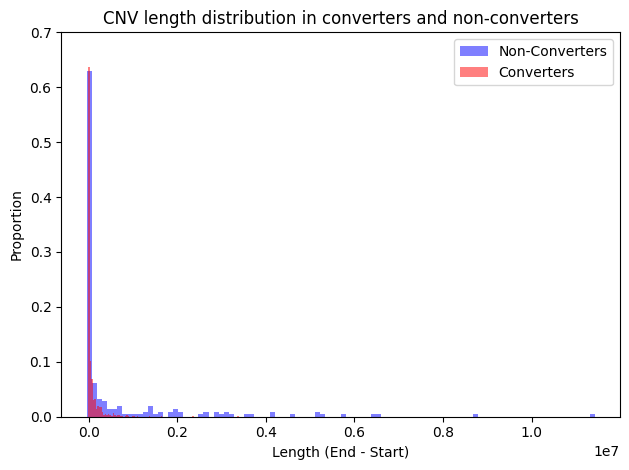

In [224]:
hist_converters, bins_converters = np.histogram(length_converters, bins=100)
hist_non_converters, bins_non_converters = np.histogram(length_non_converters, bins=100)

total_converters = len(length_converters)
total_non_converters = len(length_non_converters)
proportions_converters = hist_converters / total_converters
proportions_non_converters = hist_non_converters / total_non_converters

plt.bar(bins_non_converters[:-1], proportions_non_converters, width=(bins_non_converters[1]-bins_non_converters[0]), color="b", alpha=0.5, label="Non-Converters")
plt.bar(bins_converters[:-1], proportions_converters, width=(bins_converters[1]-bins_converters[0]), color="r", alpha=0.5, label="Converters")

plt.ylim(0, 0.7)  
plt.xlabel("Length (End - Start)")
plt.ylabel("Proportion")
plt.title("CNV length distribution in converters and non-converters")
plt.legend()
plt.tight_layout()
plt.show()


In [354]:
print(f"""Average length of rares DEL >400 kb in converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DEL") & (df["Phenotype"].isin(converters))]["CNV_length"].mean():.2f}""")
print(f"""Average length of rares DUP >400 kb in converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DUP") & (df["Phenotype"].isin(converters))]["CNV_length"].mean():.2f}""")
print(f"""Average length of rares DEL >400 kb in non_converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))]["CNV_length"].mean():.2f}""")
print(f"""Average length of rares DUP >400 kb in non_converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))]["CNV_length"].mean():.2f}""")

Average length of rares DEL >400 kb in converters: 746497.40
Average length of rares DUP >400 kb in converters: 773691.32
Average length of rares DEL >400 kb in non_converters: 942566.00
Average length of rares DUP >400 kb in non_converters: 2659424.15


In [353]:
print(f"""SD length of rares DEL >400 kb in converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DEL") & (df["Phenotype"].isin(converters))]["CNV_length"].std():.2f}""")
print(f"""SD length of rares DUP >400 kb in converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DUP") & (df["Phenotype"].isin(converters))]["CNV_length"].std():.2f}""")
print(f"""SD length of rares DEL >400 kb in non_converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))]["CNV_length"].std():.2f}""")
print(f"""SD length of rares DUP >400 kb in non_converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))]["CNV_length"].std():.2f}""")

SD length of rares DEL >400 kb in converters: 585158.96
SD length of rares DUP >400 kb in converters: 543869.84
SD length of rares DEL >400 kb in non_converters: 602544.68
SD length of rares DUP >400 kb in non_converters: 2257336.69


In [355]:
print(f"""Min length of rares DEL >400 kb in converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DEL") & (df["Phenotype"].isin(converters))]["CNV_length"].min():.2f}""")
print(f"""Min length of rares DUP >400 kb in converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DUP") & (df["Phenotype"].isin(converters))]["CNV_length"].min():.2f}""")
print(f"""Min length of rares DEL >400 kb in non_converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))]["CNV_length"].min():.2f}""")
print(f"""Min length of rares DUP >400 kb in non_converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))]["CNV_length"].min():.2f}""")

Min length of rares DEL >400 kb in converters: 400384.00
Min length of rares DUP >400 kb in converters: 404366.00
Min length of rares DEL >400 kb in non_converters: 526687.00
Min length of rares DUP >400 kb in non_converters: 429567.00


In [356]:
print(f"""Max length of rares DEL >400 kb in converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DEL") & (df["Phenotype"].isin(converters))]["CNV_length"].max():.2f}""")
print(f"""Max length of rares DUP >400 kb in converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DUP") & (df["Phenotype"].isin(converters))]["CNV_length"].max():.2f}""")
print(f"""Max length of rares DEL >400 kb in non_converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))]["CNV_length"].max():.2f}""")
print(f"""Max length of rares DUP >400 kb in non_converters: {df[(df["CNV_length"] > 400_000) & (df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))]["CNV_length"].max():.2f}""")

Max length of rares DEL >400 kb in converters: 2379038.00
Max length of rares DUP >400 kb in converters: 3404960.00
Max length of rares DEL >400 kb in non_converters: 1633562.00
Max length of rares DUP >400 kb in non_converters: 11481588.00


## Brain genes in FEP+CONV and NON_CONV

In [144]:
unique_genes = set()
df["Protein_coding_genes"].apply(lambda x: unique_genes.update(x.split(", ")))
unique_genes = list(unique_genes)

In [ ]:
gene_id = {}

In [100]:
api_key = "5c60f73cd9bc7bce4e4a8d496e3dde241709"
db = "gene"
base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
retmode = "xml"

for gene_name in tqdm(unique_genes):
    if gene_name in gene_id:
        continue
    term = f"(Homo+sapiens%5BOrganism%5D)+AND+{gene_name}%5BGene+Name%5D"
    query_url = (
            f"{base_url}/esearch.fcgi?db={db}&term={term}&retmode={retmode}&api_key={api_key}"
    )
    response = requests.get(query_url)
    if response.status_code != 200:
        print(f"Error with {gene_name}")
    else:
        xml_content = response.content
        xml_content_dict = xmltodict.parse(xml_content)
        gene_id_list = xml_content_dict["eSearchResult"]["IdList"]["Id"]
        gene_id[gene_name] = gene_id_list

100%|██████████| 2059/2059 [00:36<00:00, 56.17it/s]  


In [99]:
unique_genes.remove("LOC150051")
unique_genes.append("TIAM1-AS1")

In [98]:
unique_genes.remove("LOC100130520")
unique_genes.append("CD300H")

In [194]:
filename = "results/gene_ids.json"

with open(filename, "w") as json_file:
    json.dump(gene_id, json_file)


In [145]:
with open("results/gene_ids.json", "r") as json_file:
    gene_id = json.load(json_file)

In [5]:
gene_expression = {}

In [45]:
#example : https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=gene&id=10149&retmode=xml

api_key = "5c60f73cd9bc7bce4e4a8d496e3dde241709"
db = "gene"
base_url = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
retmode = "xml"

for gene in tqdm(gene_id_list):
    
    if gene in gene_expression:
        continue
    
    for id in gene_id[gene]:
        
        query_url = (
            f"{base_url}/efetch.fcgi?db={db}&id={str(id)}"
            f"&retmode={retmode}&rettype=abstract&api_key={api_key}"
        )
        
        response = requests.get(query_url)
        
        if response.status_code == 200:
            xml_content = response.content
            xml_content_dict = xmltodict.parse(xml_content)
            info = xml_content_dict['Entrezgene-Set']['Entrezgene']['Entrezgene_comments']['Gene-commentary']
            for dict_info in info:
                if 'Gene-commentary_heading' in dict_info.keys():
                    if dict_info['Gene-commentary_heading'] == 'Representative Expression':
                        for comment in dict_info["Gene-commentary_comment"]['Gene-commentary']:
                            if comment["Gene-commentary_label"] == "Tissue List":
                                gene_expression[gene] = comment['Gene-commentary_text']
            break 
        
    if gene not in gene_expression:
        print(f"Error {response.status_code} with {gene}")


  0%|          | 1/322 [00:00<03:20,  1.60it/s]

Error 200 with FAM25E


  1%|          | 2/322 [00:01<03:10,  1.68it/s]

Error 200 with PTCHD4


  1%|          | 3/322 [00:01<03:08,  1.69it/s]

Error 200 with STPG2


  1%|          | 4/322 [00:02<03:04,  1.72it/s]

Error 200 with OR2T11


  2%|▏         | 5/322 [00:02<03:02,  1.74it/s]

Error 200 with TRMT12


  2%|▏         | 5/322 [00:03<03:29,  1.51it/s]


KeyboardInterrupt: 

In [29]:
filename = "results/gene_expression.json"

with open(filename, "w") as json_file:
    json.dump(gene_expression, json_file)

In [291]:
with open("results/gene_expression.json", 'r') as json_file:
    gene_expression = json.load(json_file)

In [292]:
df["Tissue_expression"] = df["Protein_coding_genes"].apply(lambda x: set(expression.strip() for gene in x.split(", ") if gene in gene_expression for expression in gene_expression[gene].split(";")))

In [293]:
brain_mask = df["Tissue_expression"].apply(lambda x: "brain" in x)

In [294]:
print(f"""Number of rares DEL expressed in brain in converters: {sum(brain_mask & (df["Type"] == "DEL") & (df["Phenotype"].isin(converters)))}""")
print(f"""Number of rares DUP expressed in brain in converters: {sum(brain_mask & (df["Type"] == "DUP") & (df["Phenotype"].isin(converters)))}""")
print(f"""Number of rares DEL expressed in brain in non_converters: {sum(brain_mask & (df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters)))}""")
print(f"""Number of rares DUP expressed in brain in non_converters: {sum(brain_mask & (df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters)))}""")

Number of rares DEL expressed in brain in converters: 248
Number of rares DUP expressed in brain in converters: 398
Number of rares DEL expressed in brain in non_converters: 45
Number of rares DUP expressed in brain in non_converters: 110


In [359]:
print(f"""Average length of rares brain DEL in converters: {df[brain_mask & (df["Type"] == "DEL") & (df["Phenotype"].isin(converters))]["CNV_length"].mean():.2f}""")
print(f"""Average length of rares brain DUP in converters: {df[brain_mask & (df["Type"] == "DUP") & (df["Phenotype"].isin(converters))]["CNV_length"].mean():.2f}""")
print(f"""Average length of rares brain DEL in non_converters: {df[brain_mask & (df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))]["CNV_length"].mean():.2f}""")
print(f"""Average length of rares brain DUP in non_converters: {df[brain_mask & (df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))]["CNV_length"].mean():.2f}""")

Average length of rares brain DEL in converters: 65259.02
Average length of rares brain DUP in converters: 113879.91
Average length of rares brain DEL in non_converters: 97025.67
Average length of rares brain DUP in non_converters: 1253044.82


In [360]:
print(f"""SD length of rares brain DEL in converters: {df[brain_mask & (df["Type"] == "DEL") & (df["Phenotype"].isin(converters))]["CNV_length"].std():.2f}""")
print(f"""SD length of rares brain DUP in converters: {df[brain_mask & (df["Type"] == "DUP") & (df["Phenotype"].isin(converters))]["CNV_length"].std():.2f}""")
print(f"""SD length of rares brain DEL in non_converters: {df[brain_mask & (df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))]["CNV_length"].std():.2f}""")
print(f"""SD length of rares brain DUP in non_converters: {df[brain_mask & (df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))]["CNV_length"].std():.2f}""")

SD length of rares brain DEL in converters: 185938.85
SD length of rares brain DUP in converters: 186430.59
SD length of rares brain DEL in non_converters: 266222.09
SD length of rares brain DUP in non_converters: 2018210.90


In [358]:
print(f"""Min length of rares brain DEL in converters: {df[brain_mask & (df["Type"] == "DEL") & (df["Phenotype"].isin(converters))]["CNV_length"].min():.2f}""")
print(f"""Min length of rares brain DUP in converters: {df[brain_mask & (df["Type"] == "DUP") & (df["Phenotype"].isin(converters))]["CNV_length"].min():.2f}""")
print(f"""Min length of rares brain DEL in non_converters: {df[brain_mask & (df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))]["CNV_length"].min():.2f}""")
print(f"""Min length of rares brain DUP in non_converters: {df[brain_mask & (df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))]["CNV_length"].min():.2f}""")

Min length of rares brain DEL in converters: 9999.00
Min length of rares brain DUP in converters: 10115.00
Min length of rares brain DEL in non_converters: 10495.00
Min length of rares brain DUP in non_converters: 10765.00


In [357]:
print(f"""Max length of rares brain DEL in converters: {df[brain_mask & (df["Type"] == "DEL") & (df["Phenotype"].isin(converters))]["CNV_length"].max():.2f}""")
print(f"""Max length of rares brain DUP in converters: {df[brain_mask & (df["Type"] == "DUP") & (df["Phenotype"].isin(converters))]["CNV_length"].max():.2f}""")
print(f"""Max length of rares brain DEL in non_converters: {df[brain_mask & (df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))]["CNV_length"].max():.2f}""")
print(f"""Max length of rares brain DUP in non_converters: {df[brain_mask & (df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))]["CNV_length"].max():.2f}""")

Max length of rares brain DEL in converters: 2379038.00
Max length of rares brain DUP in converters: 1646751.00
Max length of rares brain DEL in non_converters: 1633562.00
Max length of rares brain DUP in non_converters: 11481588.00


In [302]:
def remove_empty_strings(s):
    return {item for item in s if item != ""}

df['Tissue_expression'] = df['Tissue_expression'].apply(remove_empty_strings)
df['Tissue_expression'] = df['Tissue_expression'].apply(lambda x: ", ".join(x))


In [229]:
df.to_csv("results/cnv_rares.csv", index=False)

## Statistical analysis

In [315]:
data = {
    "FEP + CONV": [6552, 7381, 4, 0, 370, 56367, 10, 248, 512, 120151, 34, 398],
    "NCONV": [1444, 1611, 1, 0, 76, 75747, 3, 45, 135, 1072063, 52, 110]
}

index = [
    "nb_DEL",
    "nb_DUP",
    "nb_DEL_patho",
    "nb_DUP_patho",
    "nb_DEL_VUS_rares",
    "DEL_VUS_rares_size",
    "nb_DEL_VUS_rares_size_>_400kb",
    "nb_DEL_VUS_rares_in_brain",
    "nb_DUP_VUS_rares",
    "DUP_VUS_rares_size",
    "nb_DUP_VUS_rares_size_>_400kb",
    "nb_DUP_VUS_rares_in_brain",
]

df_stat = pd.DataFrame(data, index=index)
df_stat = df_stat.transpose()

In [316]:
columns = df_stat.columns.to_list()
columns.remove("DEL_VUS_rares_size")
columns.remove("DUP_VUS_rares_size")

In [323]:
import scipy.stats as stats
import statsmodels.api as sm

total_cnv_conv = 13933
total_cnv_non_conv = 3055

p_values = []

for column in columns:
    
    count_conv = int(df_stat[column]["FEP + CONV"])
    count_non_conv = int(df_stat[column]["NCONV"])

    # Z-test for proportions
    _, p_value = sm.stats.proportions_ztest([count_conv, count_non_conv], 
                                                  [total_cnv_conv, total_cnv_non_conv])
        
    p_values.append(p_value)

#_, adjusted_p_values, _, _ = sm.stats.multipletests(p_values, method="fdr_bh")

for i, p in enumerate(p_values):
    df_stat.at["p-value", columns[i]] = p
    df_stat.at["DIFF", columns[i]] = p < 0.05

In [383]:
df = pd.read_csv("results/cnv_rares.csv")

In [309]:
del_conv_mask = (df["Type"] == "DEL") & (df["Phenotype"].isin(converters))
dup_conv_mask = (df["Type"] == "DUP") & (df["Phenotype"].isin(converters))
del_non_conv_mask = (df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))
dup_non_conv_mask = (df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))

In [318]:
del_conv_data = df[del_conv_mask]["CNV_length"].to_list()
del_non_conv_data = df[del_non_conv_mask]["CNV_length"].to_list()
dup_conv_data = df[dup_conv_mask]["CNV_length"].to_list()
dup_non_conv_data = df[dup_non_conv_mask]["CNV_length"].to_list()

_, p_value_del = stats.ttest_ind(del_conv_data, del_non_conv_data)
_, p_value_dup = stats.ttest_ind(dup_conv_data, dup_non_conv_data)

df_stat.at["p-value", "DEL_VUS_rares_size"] = p_value_del
df_stat.at["DIFF", "DEL_VUS_rares_size"] = p_value_del < 0.05
df_stat.at["p-value", "DUP_VUS_rares_size"] = p_value_dup
df_stat.at["DIFF", "DUP_VUS_rares_size"] = p_value_dup < 0.05


/tmp/ipykernel_674/1724715251.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_stat.at["DIFF", "DEL_VUS_rares_size"] = p_value_del < 0.05
/tmp/ipykernel_674/1724715251.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_stat.at["DIFF", "DUP_VUS_rares_size"] = p_value_dup < 0.05


In [319]:
df_stat.to_csv("results/stats.csv")

,nb_DEL,nb_DUP,nb_DEL_patho,nb_DUP_patho,nb_DEL_VUS_rares,DEL_VUS_rares_size,nb_DEL_VUS_rares_size_>_400kb,nb_DEL_VUS_rares_in_brain,nb_DUP_VUS_rares,DUP_VUS_rares_size,nb_DUP_VUS_rares_size_>_400kb,nb_DUP_VUS_rares_in_brain
FEP + CONV,6552.0,7381.0,4.0,0.0,370.0,56367.0,10.0,248.0,512.0,120151.0,34.0,398.0
NCONV,1444.0,1611.0,1.0,0.0,76.0,75747.0,3.0,45.0,135.0,1072063.0,52.0,110.0
p-value,0.808458,0.808458,0.906513,NaN,0.599267,0.354002,0.632374,0.237935,0.051608,0.0,0.0,0.028747
DIFF,False,False,False,False,False,False,False,False,False,True,True,True


## Another stats for the table in article

In [325]:
df = pd.read_csv("results/cnv_phenotypes.csv")
df.dropna(subset=["Protein_coding_genes"], inplace=True)
df.reset_index(drop=True, inplace=True)
df["Start"] = df["Start"].astype(int)
df["End"] = df["End"].astype(int)
df["CNV_length"] = df["End"] - df["Start"]

converters = ["FEP", "Converter"]
non_converters = ["Non_converter"]

# Drop UHR and NUHR
df = df[df["Phenotype"].isin(converters + non_converters)]